#ENGR 8990 - Deep Learning & Engineering Applications
## Assignment 3 - Image Segmentation
Based on "NB7_FCN.ipynb", implement FCN-8s using the pretrained ResNet-18 backbone, and train and evaluate the model with following settings:

(1) Freezed backbone and only train the newly added layers. Evaluate the trained model on the test dataset.

(2) Continue with the trained network in (1), unfreezed the backbone and finetune the entire network. Evaluate the finetuned model on the test dataset.

(3) Compare and discuss the model evaluation results obtained in (1) and (2).


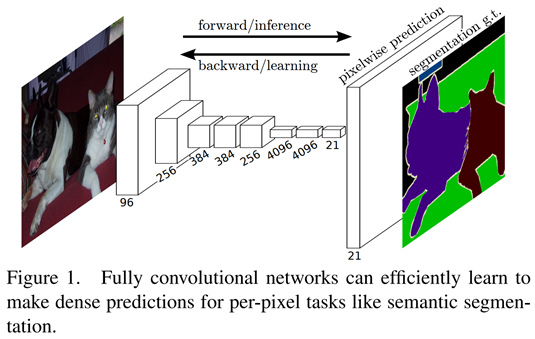

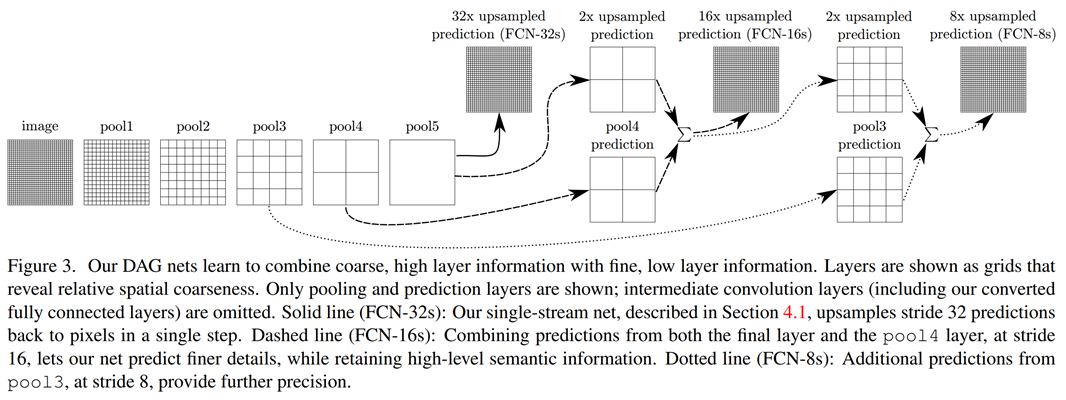

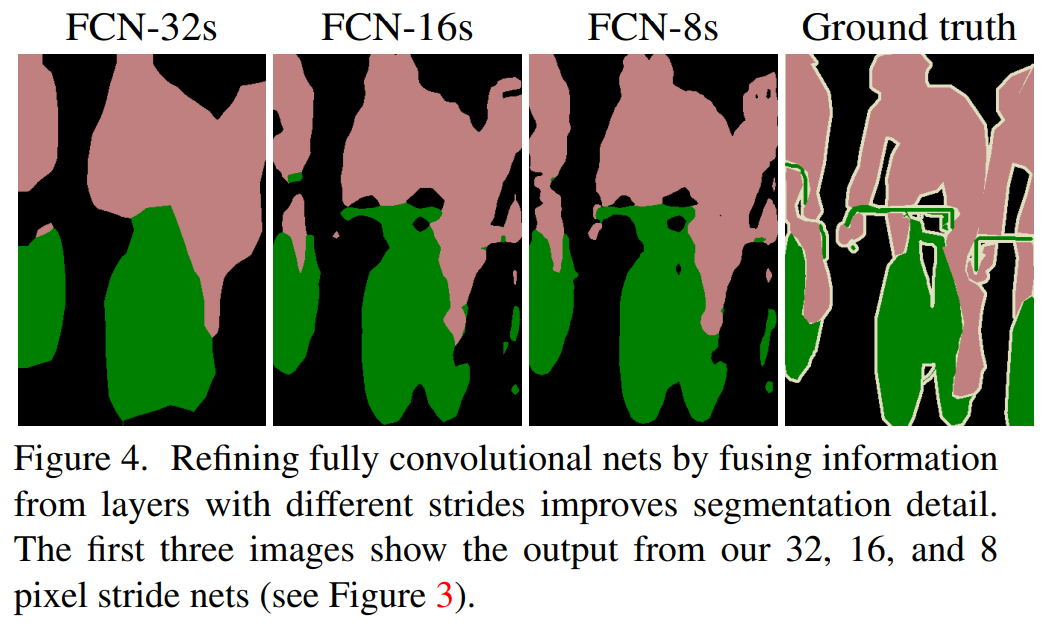

[Long et al., 2015](https://arxiv.org/abs/1411.4038)

## Your codes go here:

In [ ]:
#imports
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import os
from torchvision.models import resnet50, ResNet18_Weights

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'),
                mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

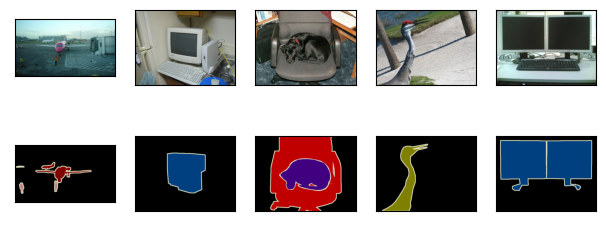

In [ ]:
#show the first five input images and their labels.
#In the label images, white and black represent borders and background, respectively,
#while the other colors correspond to different classes.
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);

### (1) Freezed backbone and only train the newly added layers. Evaluate the trained model on the test dataset.

In [ ]:
pretrained_net = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
list(pretrained_net.children())[-3:]    #showing the last three items in the list

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])
list(net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchN

In [ ]:
X = torch.rand(size=(1, 3, 320, 480))

In [ ]:
net(X).shape

torch.Size([1, 512, 10, 15])

In [ ]:
num_classes = 21

In [ ]:
class fcn8(nn.Module):
    def __init__(self, net, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.net = net
        self.conv5 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsamplex2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size =4, padding = 1, stride = 2)
        self.conv4 = nn.Conv2d(256, num_classes, kernel_size = 1)
        self.conv3 = nn.Conv2d(128, num_classes, kernel_size = 1)
        self.upsamplex8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 16, padding = 4, stride = 8)
    def forward(self, x):
        net = self.net
        x1 = net[0:6](x)
        x2 = net[6](x1)
        x3 = net[7](x2)
        x3 = self.upsamplex2(self.conv5(x3))
        x2 = self.upsamplex2(self.conv4(x2) + x3)
        return self.upsamplex8(self.conv3(x1) + x2)

In [ ]:
list(net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchN

In [ ]:
net(X).shape

torch.Size([1, 512, 10, 15])

In [ ]:
FCN8 = fcn8(net, num_classes)

In [ ]:
pl_toolkitdef bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [ ]:
W2 = bilinear_kernel(num_classes, num_classes, 4)
W8 = bilinear_kernel(num_classes, num_classes, 16)
FCN8.upsamplex2.weight.data.copy_(W2)
FCN8.upsamplex8.weight.data.copy_(W8)

tensor([[[[0.0039, 0.0117, 0.0195,  ..., 0.0195, 0.0117, 0.0039],
          [0.0117, 0.0352, 0.0586,  ..., 0.0586, 0.0352, 0.0117],
          [0.0195, 0.0586, 0.0977,  ..., 0.0977, 0.0586, 0.0195],
          ...,
          [0.0195, 0.0586, 0.0977,  ..., 0.0977, 0.0586, 0.0195],
          [0.0117, 0.0352, 0.0586,  ..., 0.0586, 0.0352, 0.0117],
          [0.0039, 0.0117, 0.0195,  ..., 0.0195, 0.0117, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
FCN8(X).shape

torch.Size([1, 21, 320, 480])

In [ ]:
FCN8.parameters

<bound method Module.parameters of fcn8(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
for parameter in FCN8.parameters():
    parameter.requires_grad = True
for parameter in FCN8.net.parameters():
    parameter.requires_grad = False

In [ ]:
for name, param in FCN8.named_parameters():
    #print(name)
    if param.requires_grad:print(name)

conv5.weight
conv5.bias
upsamplex2.weight
upsamplex2.bias
conv4.weight
conv4.bias
conv3.weight
conv3.bias
upsamplex8.weight
upsamplex8.bias


In [ ]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 100, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(FCN8.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(FCN8, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = FCN8(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

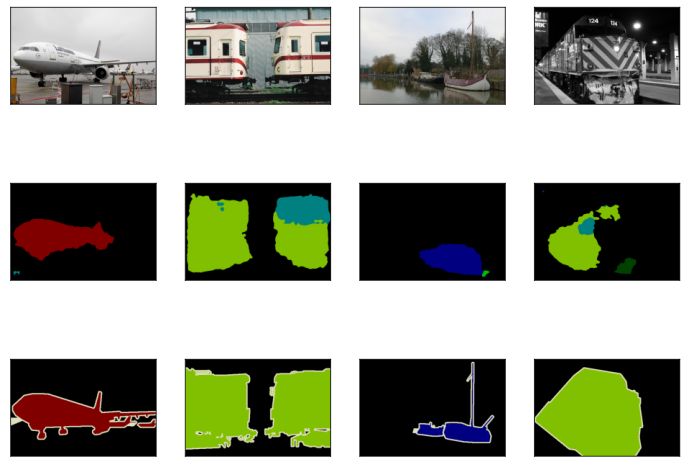

In [ ]:
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=3);


In [ ]:
test_images[0]


tensor([[[221, 212, 215,  ..., 226, 221, 223],
         [214, 205, 208,  ..., 222, 217, 219],
         [217, 208, 210,  ..., 223, 218, 220],
         ...,
         [ 98, 100,  94,  ..., 198, 194, 195],
         [ 93,  92,  93,  ..., 196, 193, 195],
         [ 86, 101, 103,  ..., 196, 193, 195]],

        [[221, 212, 215,  ..., 226, 221, 223],
         [214, 205, 208,  ..., 222, 217, 219],
         [217, 208, 210,  ..., 223, 218, 220],
         ...,
         [ 85,  87,  81,  ..., 198, 194, 193],
         [ 80,  79,  80,  ..., 196, 193, 193],
         [ 73,  88,  90,  ..., 196, 193, 193]],

        [[221, 212, 215,  ..., 226, 221, 223],
         [214, 205, 208,  ..., 222, 217, 219],
         [217, 208, 210,  ..., 223, 218, 220],
         ...,
         [ 69,  71,  65,  ..., 198, 194, 194],
         [ 64,  63,  64,  ..., 196, 193, 194],
         [ 57,  72,  74,  ..., 196, 193, 194]]], dtype=torch.uint8)

In [ ]:
test_labels[0]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

### (2) Continue with the trained network in (1), unfreezed the backbone and finetune the entire network. Evaluate the finetuned model on the test dataset.

In [ ]:
for parameter in FCN8.parameters():
    parameter.requires_grad = True

In [ ]:
for name, param in FCN8.named_parameters():
    #print(name)
    if param.requires_grad:print(name)

In [ ]:
num_epochs, lr, wd, devices = 20, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(FCN8.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(FCN8, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=3);


### (3) Compare and discuss the model evaluation results obtained in (1) and (2).

In [ ]:
#As you can see test accuracy in a 100 epoch training cycle of only the unfrozen layers results in 84.2%
#However, unfreezing the backbone and training the whole model again for just 20 epochs more allows you to attain 87.0% accuracy
#This is a 2.8% accuracy increase which is a lot in the AI space
#A wish man once said, "What does a marginal improvement mean in academia? That you have publishable results"